# Preliminary analysis of RCA in vitro trials (for multiple acquisition)

In [1]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

import cv2
import skimage
import scipy.ndimage, scipy.stats

## Crop and save images

In [283]:
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_0.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_100.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_100_2.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_20.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_40.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_60.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_80.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_80_2.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/neg_ctrol_imager.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten

In [284]:
file = files[7]
print(file)
img = tif.imread(file)
img_488 = img[1,:,:]
img_555 = img[2,:,:]

/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250415_RCA_fluo_imaging/100_to_80_2.tif


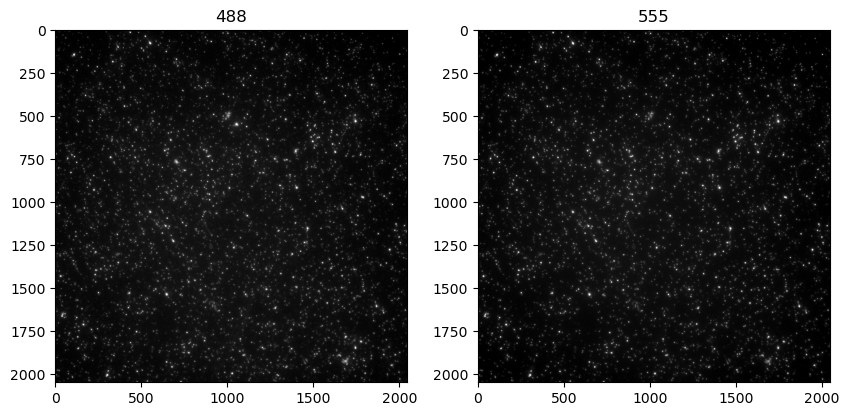

In [285]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.title("488")
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.title("555")
plt.show()

Plot a line profile in the diagonal direction

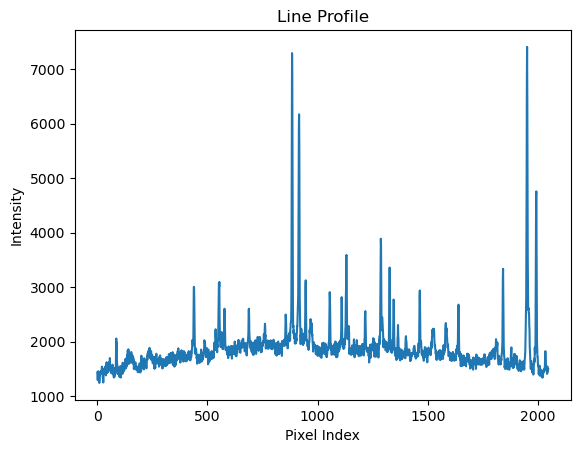

In [286]:
def plot_line_profile(img, start, end):
    # Create a mask for the line
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.line(mask, start, end, 255, 1)

    # Get the coordinates of the line
    coords = np.column_stack(np.where(mask > 0))

    # Get the pixel values along the line
    line_values = img[coords[:, 0], coords[:, 1]]

    # Plot the line profile
    plt.plot(line_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Line Profile')
    plt.show()
# Define the start and end points of the line
start = (0, 0)
end = (img_488.shape[1] - 1, img_488.shape[0] - 1)
# Plot the line profile for the first image
plot_line_profile(img_555, start, end)

Difference of guassian and then local maxima to detect spots

In [287]:
def vis_roll_ball(img, radius):
    # slightly blur the image to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # rolling ball algorithm to remove background
    background = skimage.restoration.rolling_ball(img, radius=radius)
    img_sub = img - background
    
    # set figure size
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.clim(np.percentile(img, 5), np.percentile(img, 99.9))
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(background, cmap='gray')
    plt.title('Background')
    plt.clim(np.percentile(background, 5), np.percentile(background, 99.9))
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_sub, cmap='gray')
    plt.title('Subtracted Image')
    plt.clim(np.percentile(img_sub, 5), np.percentile(img_sub, 99.9))
    plt.axis('off')

    plt.show()

    start = (0, 0)
    end = (img_sub.shape[1] - 1, img_sub.shape[0] - 1)
    plot_line_profile(img_sub, start, end)
    
def vis_gaussian(img, sigma1, sigma2):
    # difference of guassian sigma1 = 2, sigma2 = 10
    img_sig1 = skimage.filters.gaussian(img, sigma=sigma1, preserve_range=True)
    img_sig2 = skimage.filters.gaussian(img, sigma=sigma2, preserve_range=True)
    img_sub = img_sig1 - img_sig2
    
    return img_sub

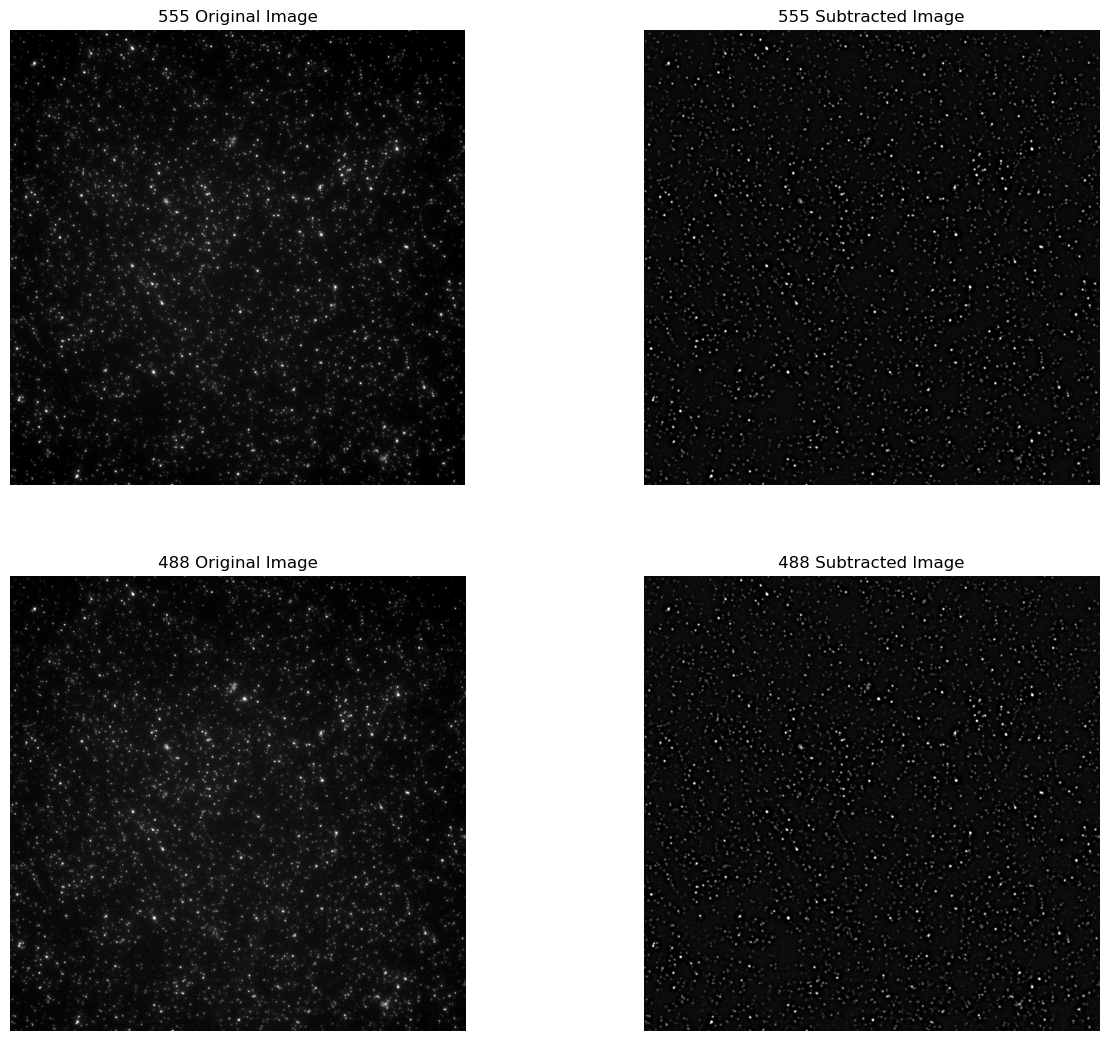

In [288]:
img_555_sub = vis_gaussian(img_555, 2, 10)
img_488_sub = vis_gaussian(img_488, 2, 10)

plt.figure(figsize=(15, 13), dpi=100)
plt.subplot(221)
plt.imshow(img_555, cmap='gray')
plt.title('555 Original Image')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.axis('off')
plt.subplot(222)
plt.imshow(img_555_sub, cmap='gray')
plt.title('555 Subtracted Image')
plt.clim(np.percentile(img_555_sub, 5), np.percentile(img_555_sub, 99.9))
plt.axis('off')
plt.subplot(223)
plt.imshow(img_488, cmap='gray')
plt.title('488 Original Image')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.axis('off')
plt.subplot(224)
plt.imshow(img_488_sub, cmap='gray')
plt.title('488 Subtracted Image')
plt.clim(np.percentile(img_488_sub, 5), np.percentile(img_488_sub, 99.9))
plt.axis('off')
plt.show()

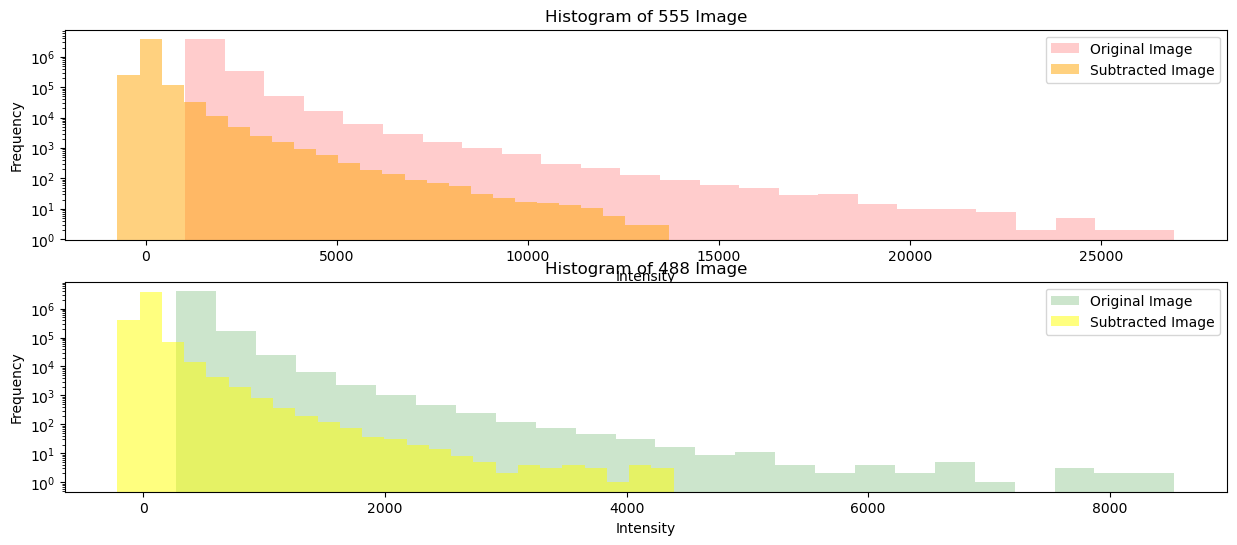

In [289]:

# plot the histogram before and after background subtraction
plt.figure(figsize=(15, 6), dpi=100)
plt.subplot(211)
# plt.hist(img_555_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_555.flatten(), bins=25, color='red', alpha=0.2, label='Original Image')
plt.hist(img_555_sub.flatten(), bins=25, color='orange', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 555 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
# set y into log
plt.yscale('log')
plt.legend()
plt.subplot(212)
# plt.hist(img_488_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_488.flatten(), bins=25, color='green', alpha=0.2, label='Original Image')
plt.hist(img_488_sub.flatten(), bins=25, color='yellow', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 488 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()

Local max (circular kernel)

In [290]:
def maximum_filter(img, radius):
    # set a circular kernel
    kernel = cv2.circle(np.zeros((radius*2+1, radius*2+1), dtype=np.uint8), (radius, radius), radius, 1, -1)
    
    # apply the maximum filter using the circular kernel, consider a reflective border
    img_max = cv2.dilate(img, kernel, iterations=1)
    return img_max

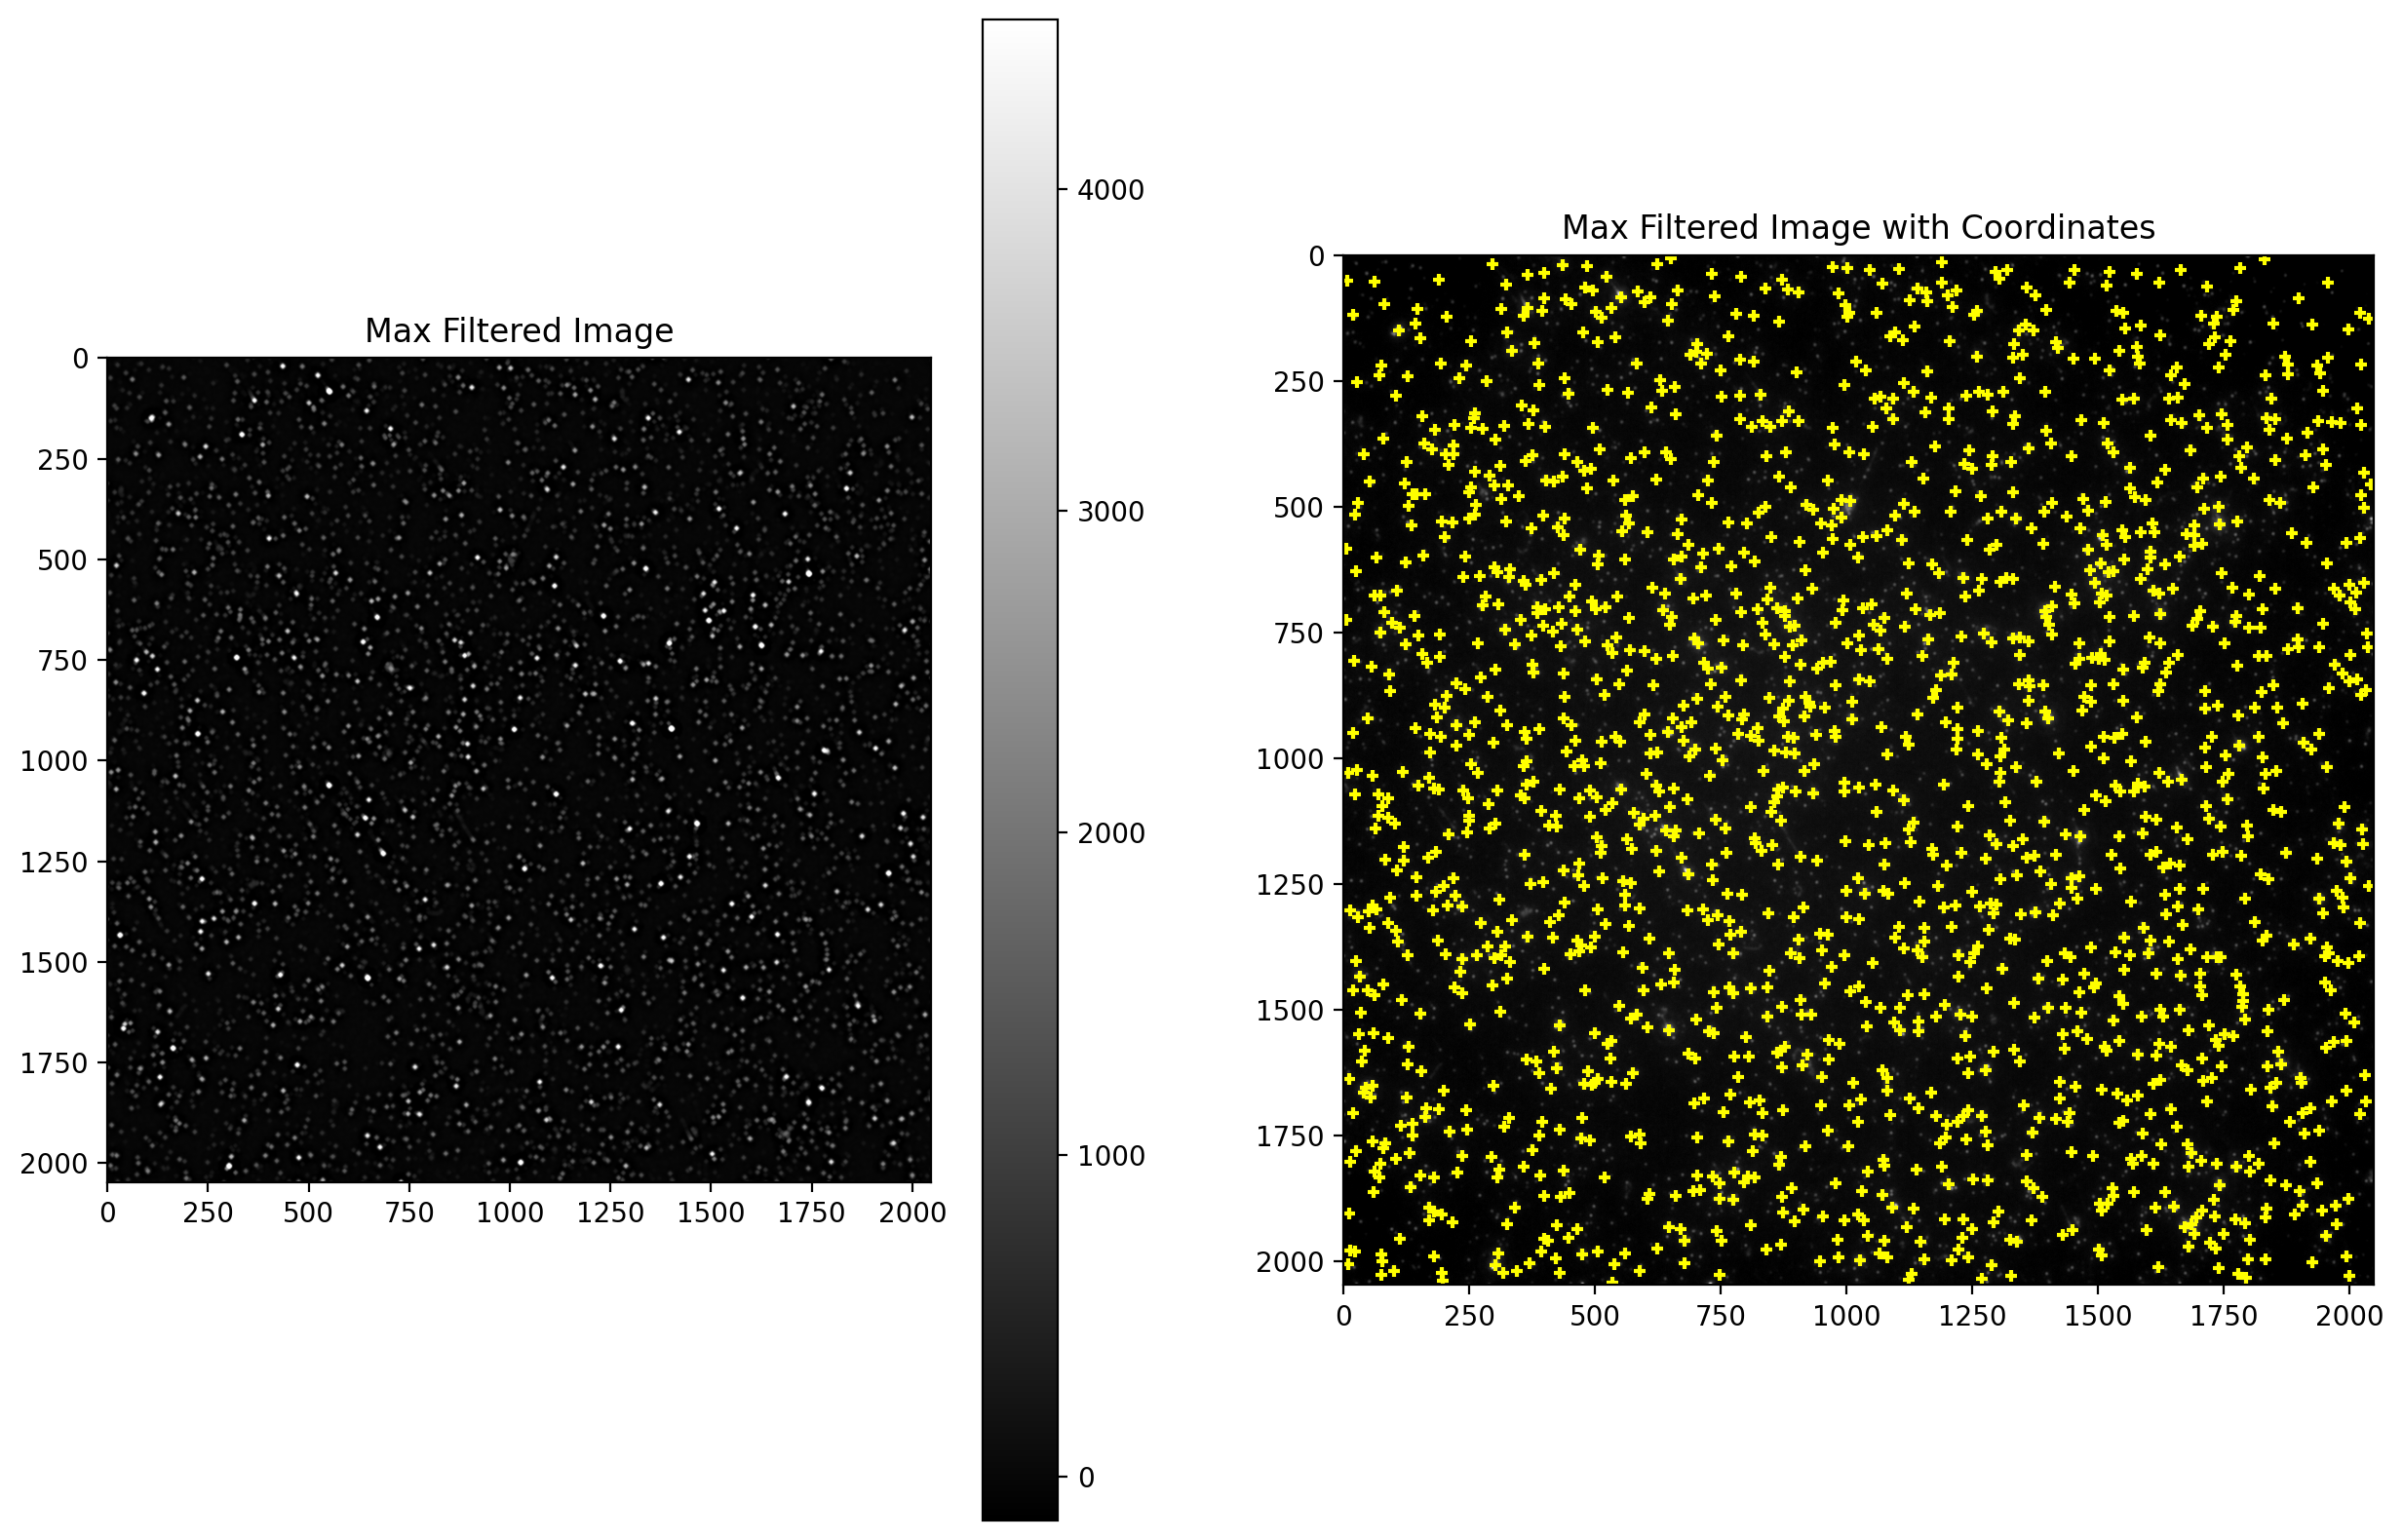

In [293]:
# img_555_max = scipy.ndimage.maximum_filter(img_555_sub, size=5)
img_555_max = maximum_filter(img_555_sub, radius=2)
thres = 1000
coordinates = skimage.feature.peak_local_max(img_555_sub, min_distance=5, threshold_abs=thres)

plt.figure(figsize=(15, 10), dpi=200)
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Max Filtered Image')
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
plt.colorbar()

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('Max Filtered Image with Coordinates')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))

# plt.colorbar()
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
    
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
    
plt.show()

Coarse peak intensity correlation

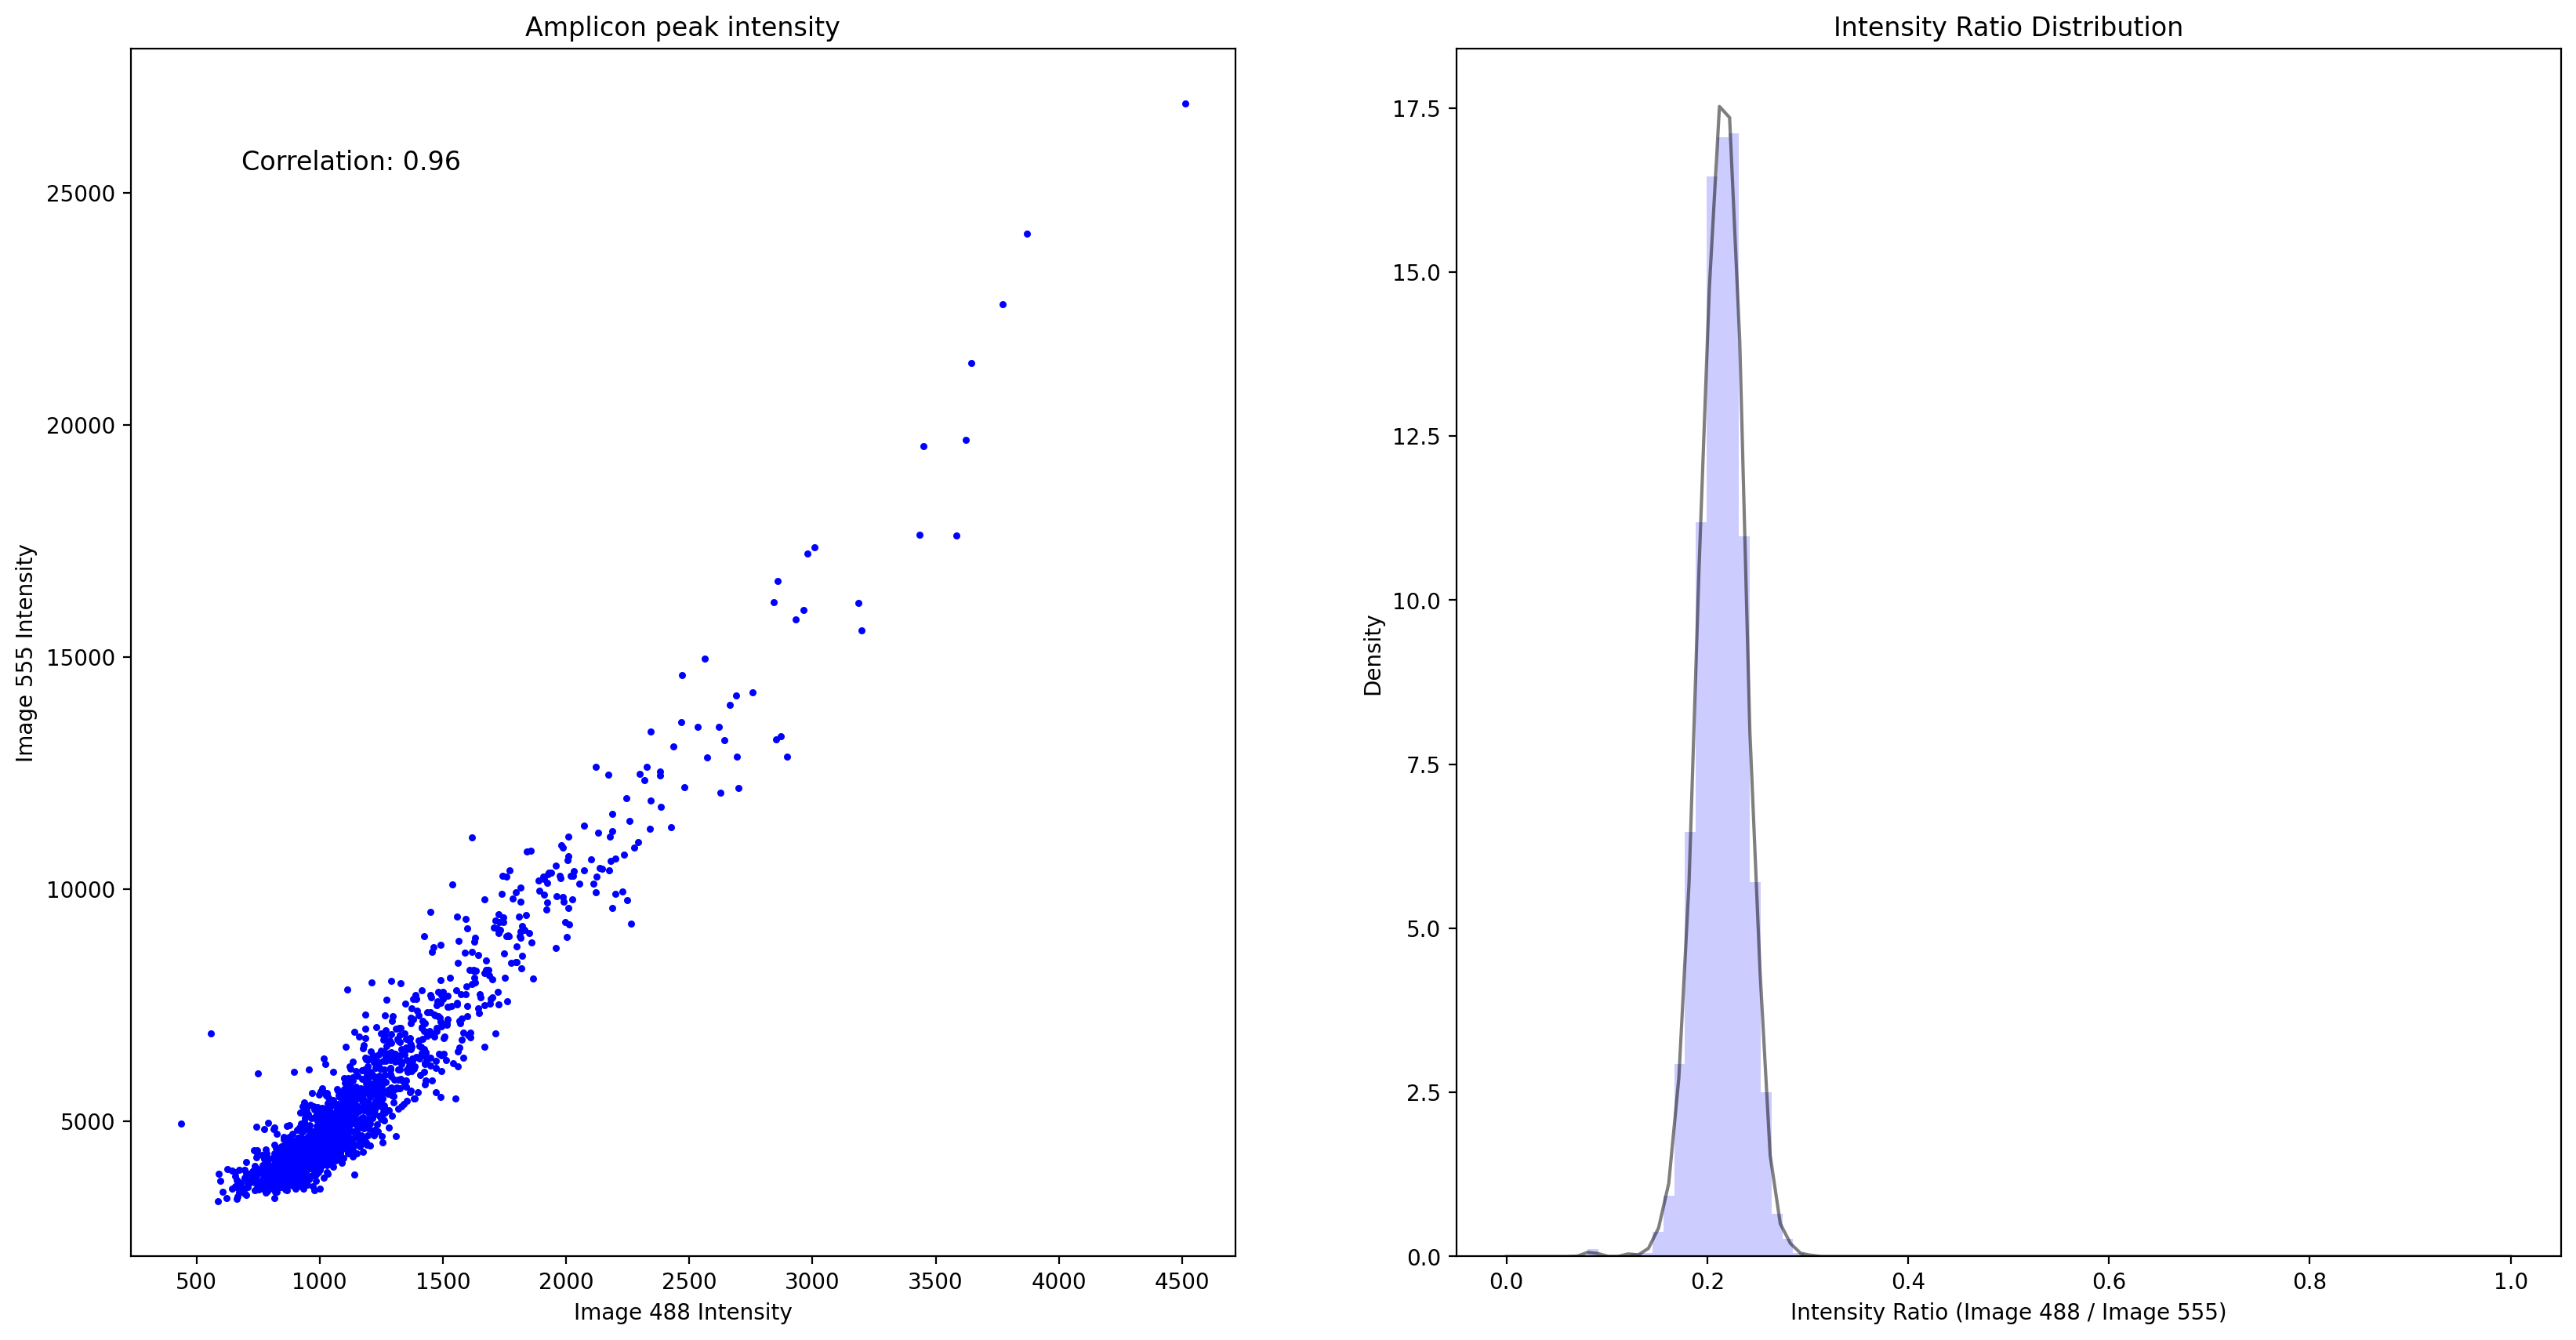

In [294]:
# plot a scatter plot correlating the intensity of img_488 and img_555 in the same coordinates
def plot_scatter(img1, img2, coordinates):
    # Get the pixel values at the coordinates
    values1 = img1[coordinates[:, 0], coordinates[:, 1]]
    values2 = img2[coordinates[:, 0], coordinates[:, 1]]

    # remove data pair if any of them is higher than 60000
    mask = (values1 < 60000) & (values2 < 60000)
    values1 = values1[mask]
    values2 = values2[mask]
    
    # ratio
    ratio = values1/values2
    
    # Plot the scatter plot
    plt.figure(figsize=(20, 10), dpi = 200)
    plt.subplot(121)
    plt.scatter(values1, values2, c='blue', s=5)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Image 488 Intensity')
    plt.ylabel('Image 555 Intensity')
    plt.title('Amplicon peak intensity')
    # compute the correlation coefficient
    correlation = np.corrcoef(values1, values2)[0, 1]
    plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.subplot(122)
    # plot a smoothened histogram of the intensity ratio
    plt.hist(ratio, bins=20, color='blue', alpha=0.2, density=True)
    kde = scipy.stats.gaussian_kde(ratio)
    x = np.linspace(0, 1, 100)
    plt.plot(x, kde(x), color='black', alpha=0.5)
    plt.xlabel('Intensity Ratio (Image 488 / Image 555)')
    plt.ylabel('Density')
    plt.title('Intensity Ratio Distribution')
    
    plt.show()
    
    
    
# Convert coordinates to a numpy array
coordinates = np.array(coordinates)
# Plot the scatter plot
plot_scatter(img_488, img_555, coordinates)

whole-amplicon intensity correlation

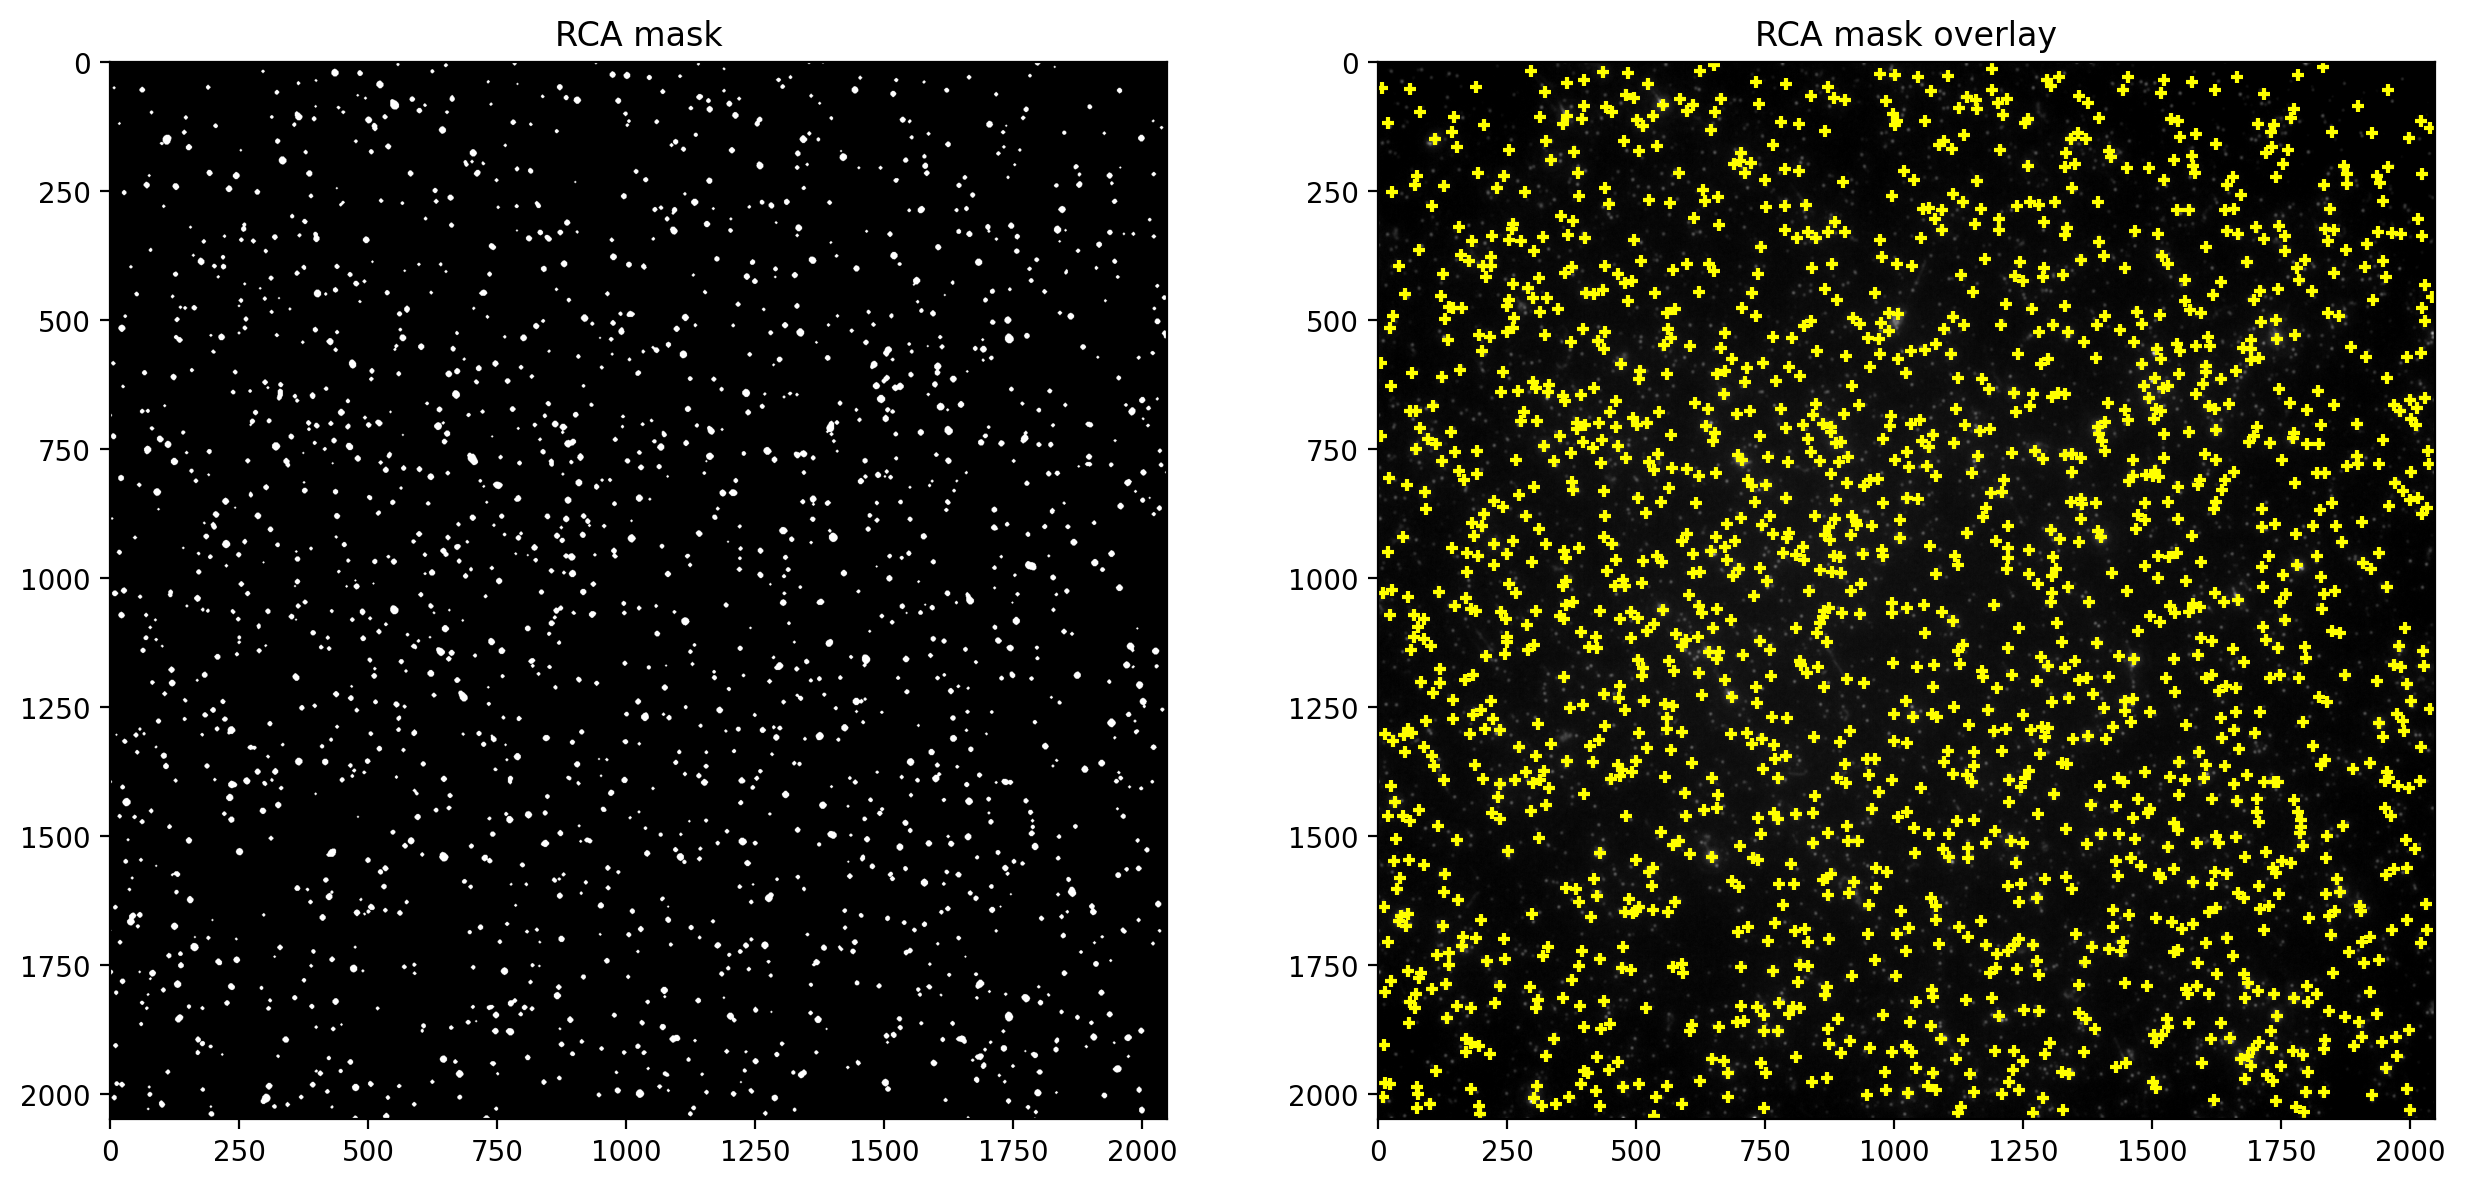

In [295]:
img_mask = img_555_max > thres

plt.figure(figsize=(15, 10), dpi = 200)
plt.subplot(121)
plt.imshow(img_mask, cmap='gray')
plt.title('RCA mask')
plt.clim(0, 1)
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('RCA mask overlay')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
plt.show()

In [296]:
# turn the mask into a label image
img_mask = skimage.measure.label(img_mask)
img_488_df = skimage.measure.regionprops_table(img_mask, img_488, properties=['label', 'area', 'mean_intensity'])
img_555_df = skimage.measure.regionprops_table(img_mask, img_555, properties=['label', 'area', 'mean_intensity'])

In [297]:
img_488_df = pd.DataFrame(img_488_df)
img_555_df = pd.DataFrame(img_555_df)

# add one column to store area*mean_intensity as total_intensity
img_488_df['total_intensity'] = img_488_df['area'] * img_488_df['mean_intensity']
img_555_df['total_intensity'] = img_555_df['area'] * img_555_df['mean_intensity']
# merge the two dataframes on label
img_df = pd.merge(img_488_df, img_555_df, on='label', suffixes=('_488', '_555'))

img_df

label  area_488  mean_intensity_488  total_intensity_488  area_555  \
0         1      44.0          705.159091              31027.0      44.0   
1         2      21.0          723.285714              15189.0      21.0   
2         3      27.0          672.592593              18160.0      27.0   
3         4      23.0          573.391304              13188.0      23.0   
4         5      15.0          578.866667               8683.0      15.0   
...     ...       ...                 ...                  ...       ...   
1701   1702     111.0          904.360360             100384.0     111.0   
1702   1703      55.0          832.381818              45781.0      55.0   
1703   1704      71.0         1118.591549              79420.0      71.0   
1704   1705      23.0          758.130435              17437.0      23.0   
1705   1706      12.0          827.333333               9928.0      12.0   

      mean_intensity_555  total_intensity_555  
0            3035.931818             133581.0  
1            3207.714286              67362.0  
2            3109.925926              83968.0  
3            3160.956522              72702.0  
4            3231.266667              48469.0  
...                  ...                  ...  
1701         3657.063063             405934.0  
1702         3376.872727             185728.0  
1703         4615.535211             327703.0  
1704         3214.260870              73928.0  
1705         3334.500000              40014.0  

[1706 rows x 7 columns]

In [298]:
# # save dataframe to csv
# output_dir = os.path.join(data_dir, 'dataframe')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# img_df.to_csv(os.path.join(output_dir, 'RCA_df_'+os.path.basename(file)[:-4]+'.csv'), index=False)

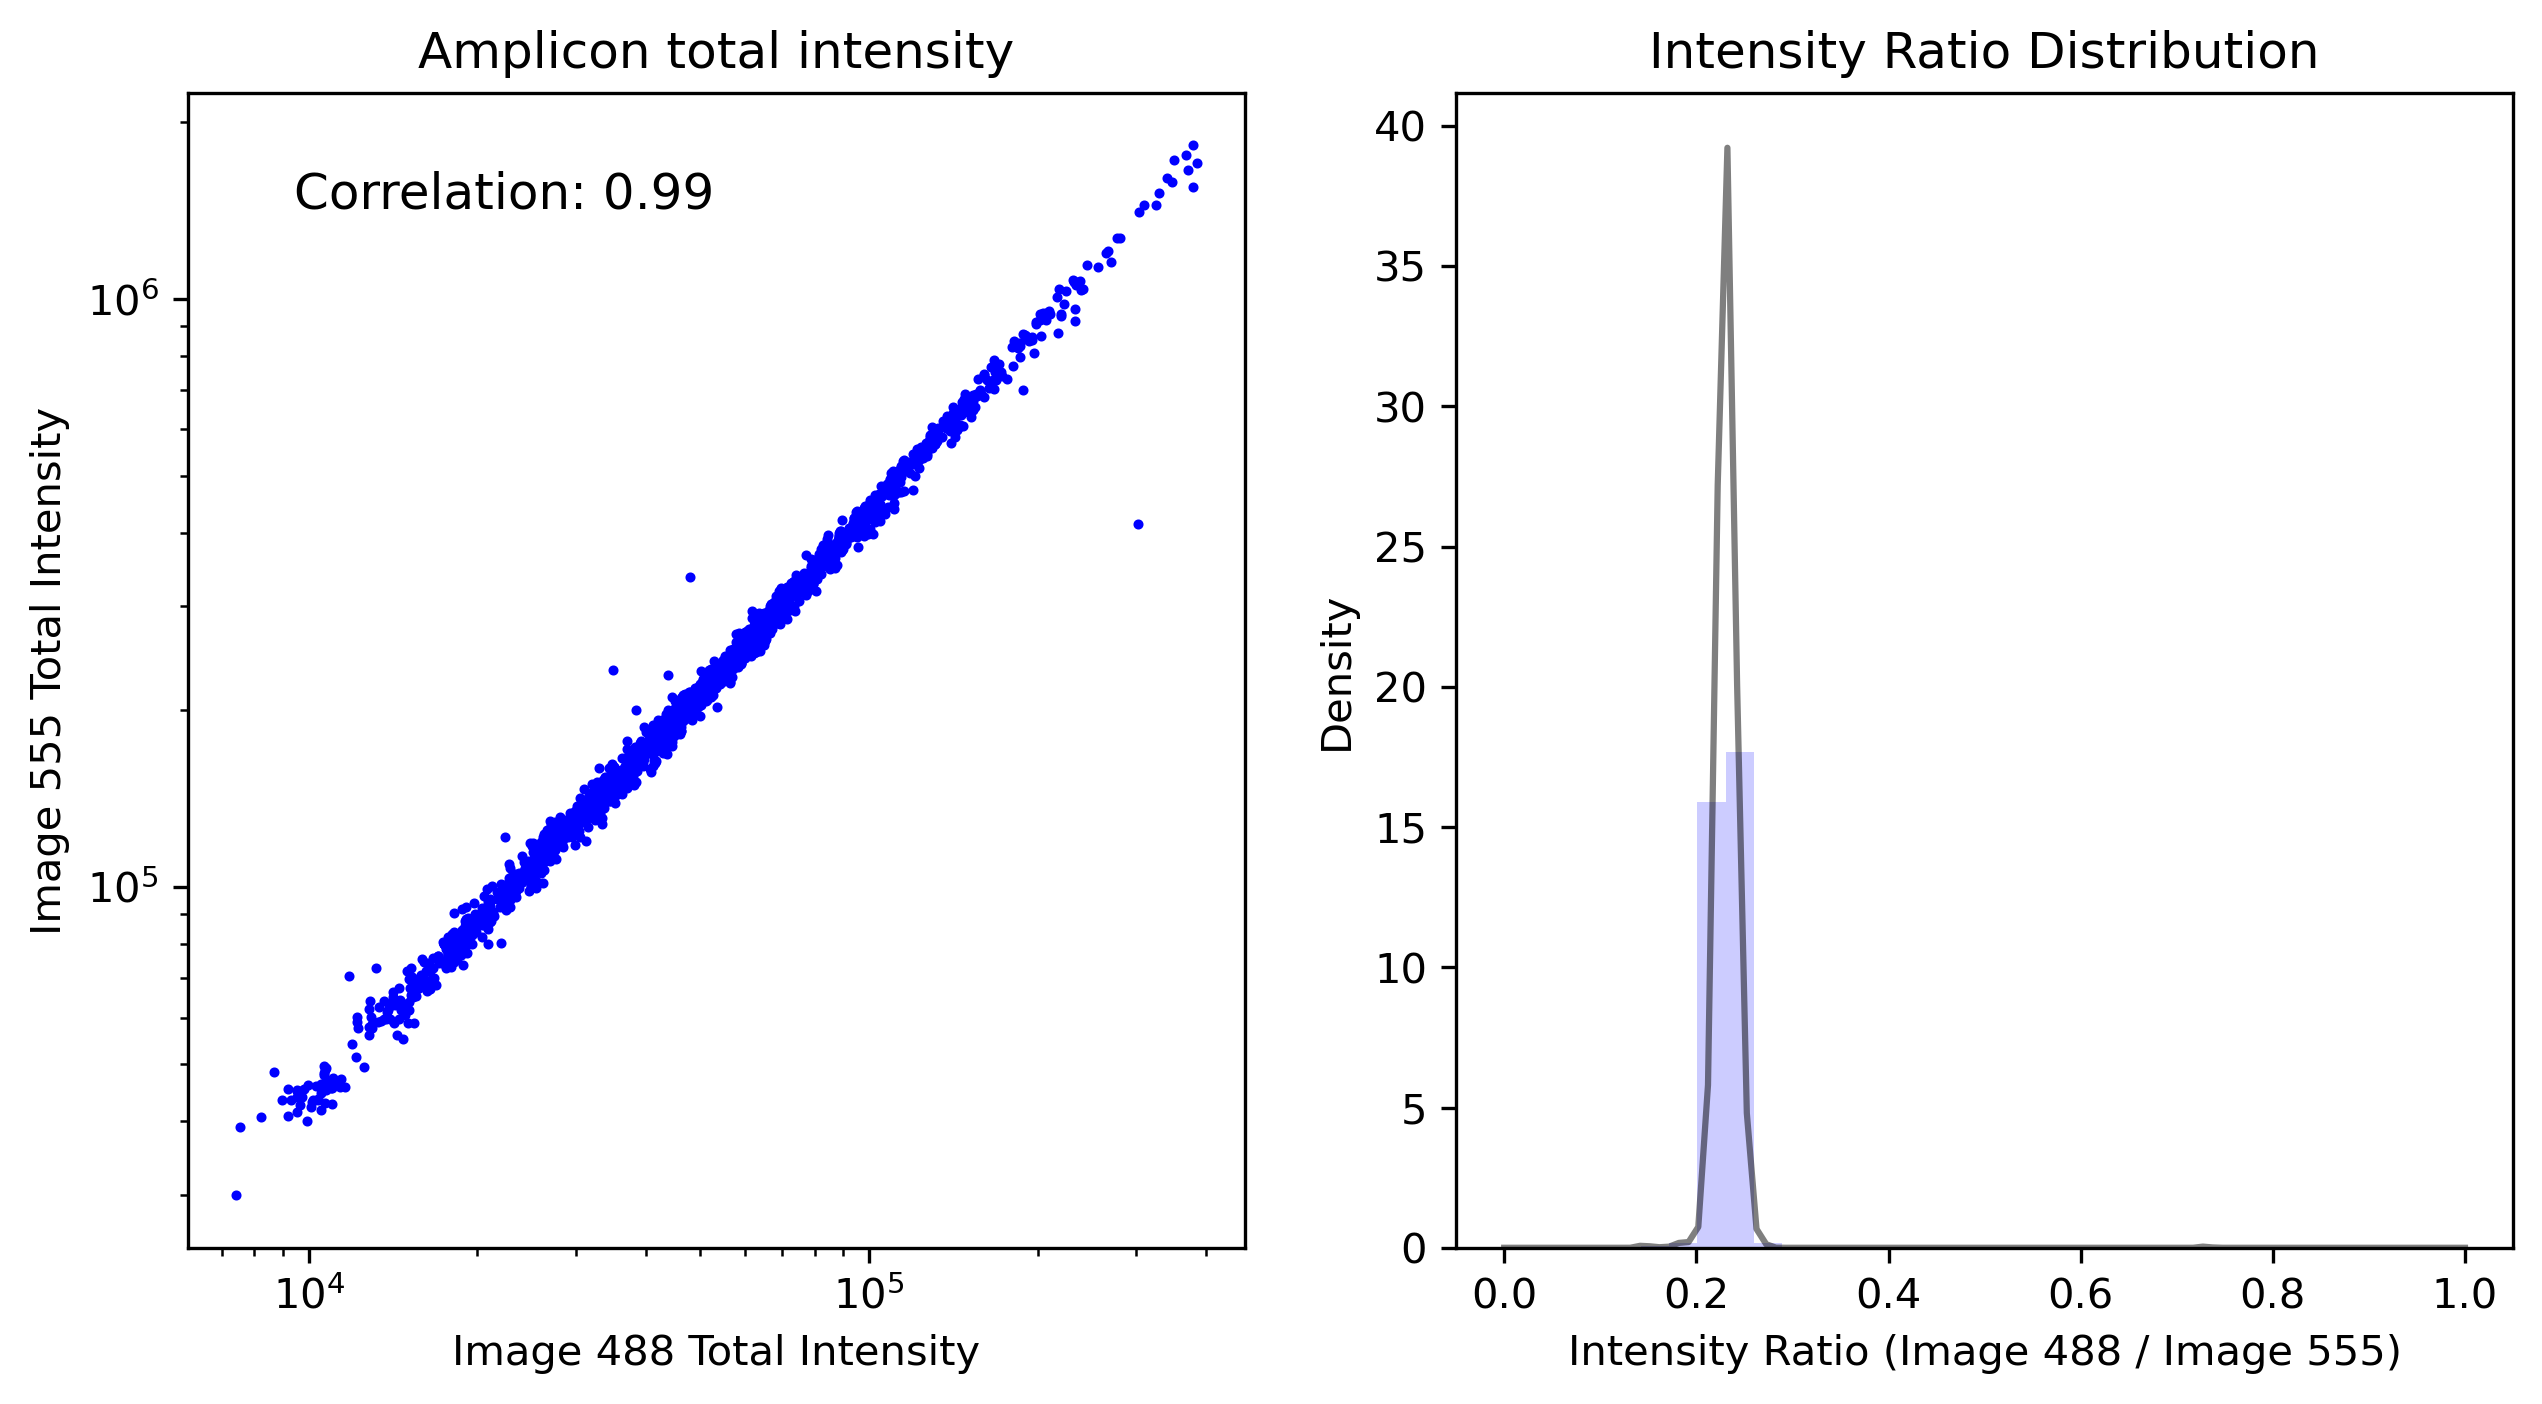

In [299]:
# plot scatter plot of total intensity
plt.figure(figsize=(10, 5), dpi = 300)
plt.subplot(121)
plt.scatter(img_df['total_intensity_488'], img_df['total_intensity_555'], c='blue', s=2)
plt.xlabel('Image 488 Total Intensity')
plt.ylabel('Image 555 Total Intensity')
plt.title('Amplicon total intensity')
# compute the correlation coefficient
correlation = np.corrcoef(img_df['total_intensity_488'], img_df['total_intensity_555'])[0, 1]
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
# plt.xlim(0, 0.5e6)
# plt.ylim(0, 2e6)
# turn on log scale
plt.xscale('log')
plt.yscale('log')
plt.subplot(122)
# plot a smoothened histogram of the intensity ratio
plt.hist(img_df['total_intensity_488']/img_df['total_intensity_555'], bins=20, density=True, alpha=0.2, color='blue')
kde = scipy.stats.gaussian_kde(img_df['total_intensity_488']/img_df['total_intensity_555'])
x = np.linspace(0, 1, 100)
plt.plot(x, kde(x), color='black', alpha=0.5)
plt.xlabel('Intensity Ratio (Image 488 / Image 555)')
plt.ylabel('Density')
plt.title('Intensity Ratio Distribution')
plt.show()

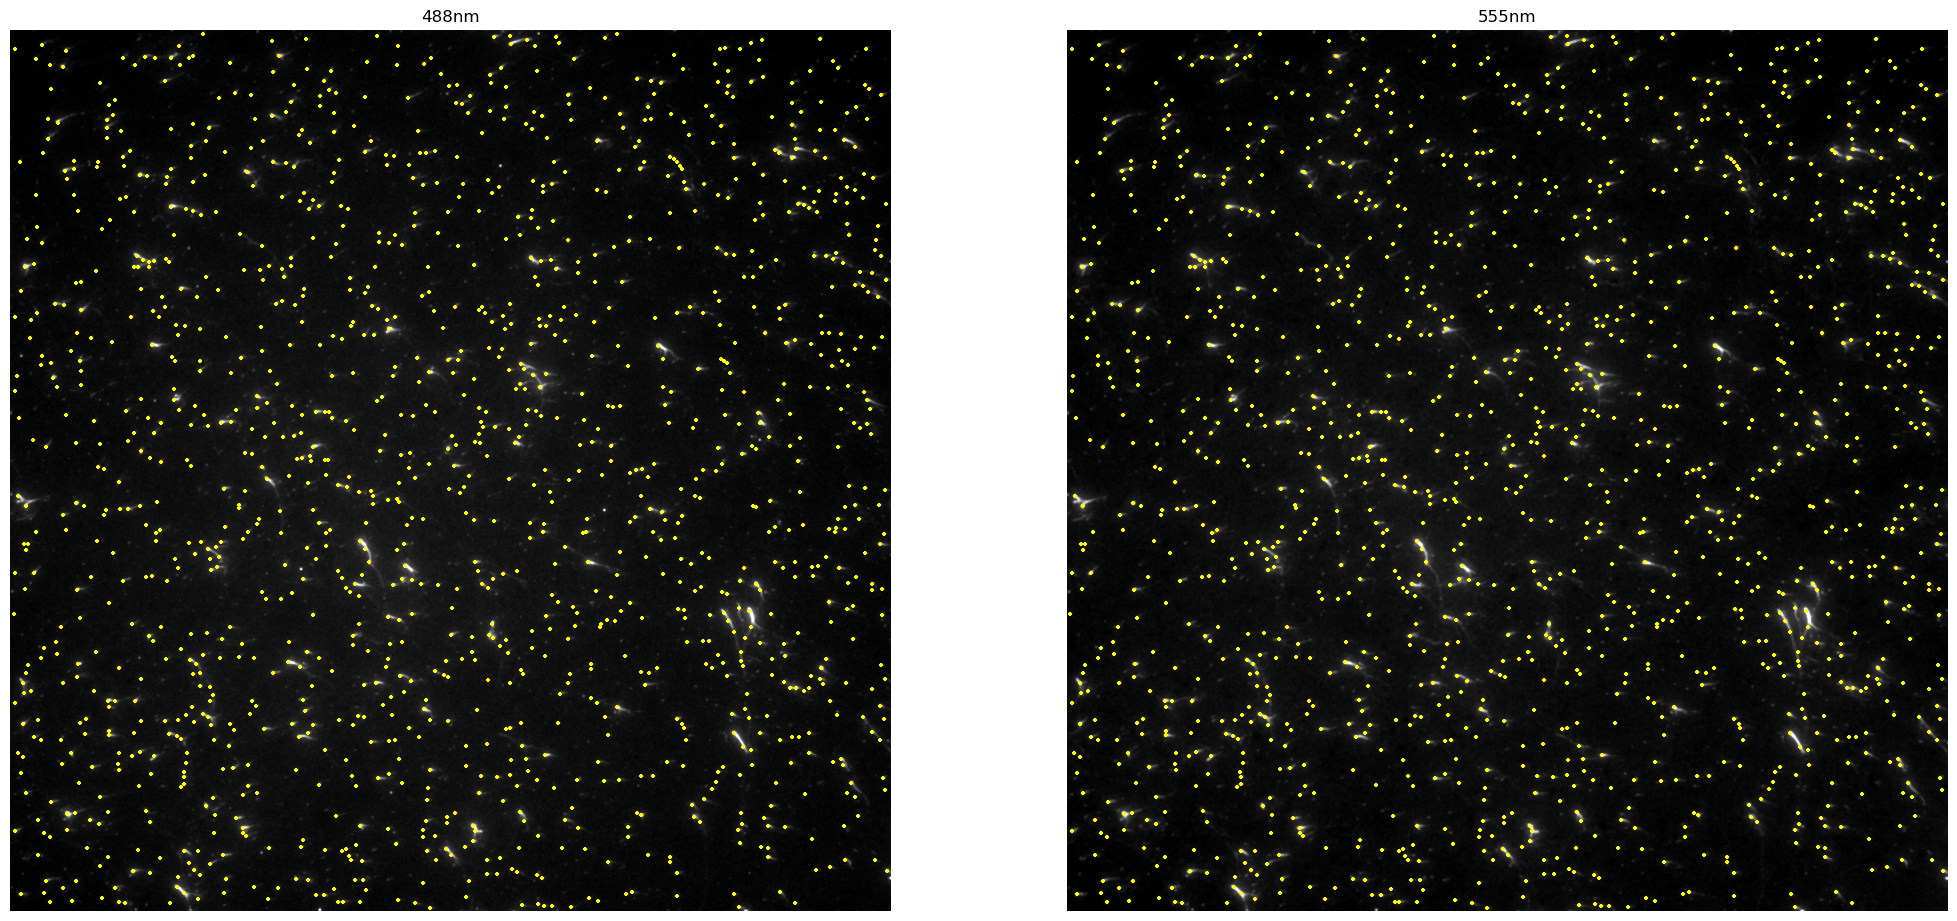

In [98]:
# plot 488 and 555 raw image overlaid with the coordinates
plt.figure(figsize=(25, 15))
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.title('488nm')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.axis('off')
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('555nm')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.axis('off')
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.show()

## Plot the distribution of all condition groups

In [201]:
df_files = os.listdir(output_dir)
print(df_files)

['RCA_df_100_to_0.csv', 'RCA_df_100_to_20.csv', 'RCA_df_100_to_100.csv', 'RCA_df_100_to_40.csv', 'RCA_df_100_to_60.csv', 'RCA_df_100_to_80.csv']


In [208]:
# create a new df for all the data
df_all = pd.DataFrame()

for file in df_files:
    if file.endswith('.csv'):
        # read the csv file
        df = pd.read_csv(os.path.join(output_dir, file))
        # add a new column for the filename
        df['filename'] = file[:-4].split('_')[-1]
        # append to the df_all
        df_all = pd.concat([df_all, df], ignore_index=True)
        
# set the datatype of each column
df_all['label'] = df_all['label'].astype(int)
df_all['area_488'] = df_all['area_488'].astype(int)
df_all['area_555'] = df_all['area_555'].astype(int)
df_all['mean_intensity_488'] = df_all['mean_intensity_488'].astype(float)
df_all['mean_intensity_555'] = df_all['mean_intensity_555'].astype(float)
df_all['total_intensity_488'] = df_all['total_intensity_488'].astype(float)
df_all['total_intensity_555'] = df_all['total_intensity_555'].astype(float)
df_all['filename'] = df_all['filename'].astype(int)

In [210]:
# sort using filename
df_all = df_all.sort_values(by='filename')
df_all

label  area_488  mean_intensity_488  total_intensity_488  area_555  \
0         1        39          445.256410              17365.0        39   
1         2        90          632.477778              56923.0        90   
2         3       101          669.356436              67605.0       101   
19       20       197          646.162437             127294.0       197   
20       21        81          589.271605              47731.0        81   
...     ...       ...                 ...                  ...       ...   
5133   2214        98         1196.612245             117268.0        98   
5134   2215        24         1199.333333              28784.0        24   
5135   2216        70         1053.371429              73736.0        70   
5136   2217        36         1092.138889              39317.0        36   
5137   2218        34         1274.205882              43323.0        34   

      mean_intensity_555  total_intensity_555  filename  
0             156.153846               6090.0         0  
1             154.411111              13897.0         0  
2             159.881188              16148.0         0  
19            202.370558              39867.0         0  
20            167.024691              13529.0         0  
...                  ...                  ...       ...  
5133         8080.653061             791904.0       100  
5134         8573.750000             205770.0       100  
5135         7050.014286             493501.0       100  
5136         7386.333333             265908.0       100  
5137         8604.676471             292559.0       100  

[9747 rows x 8 columns]

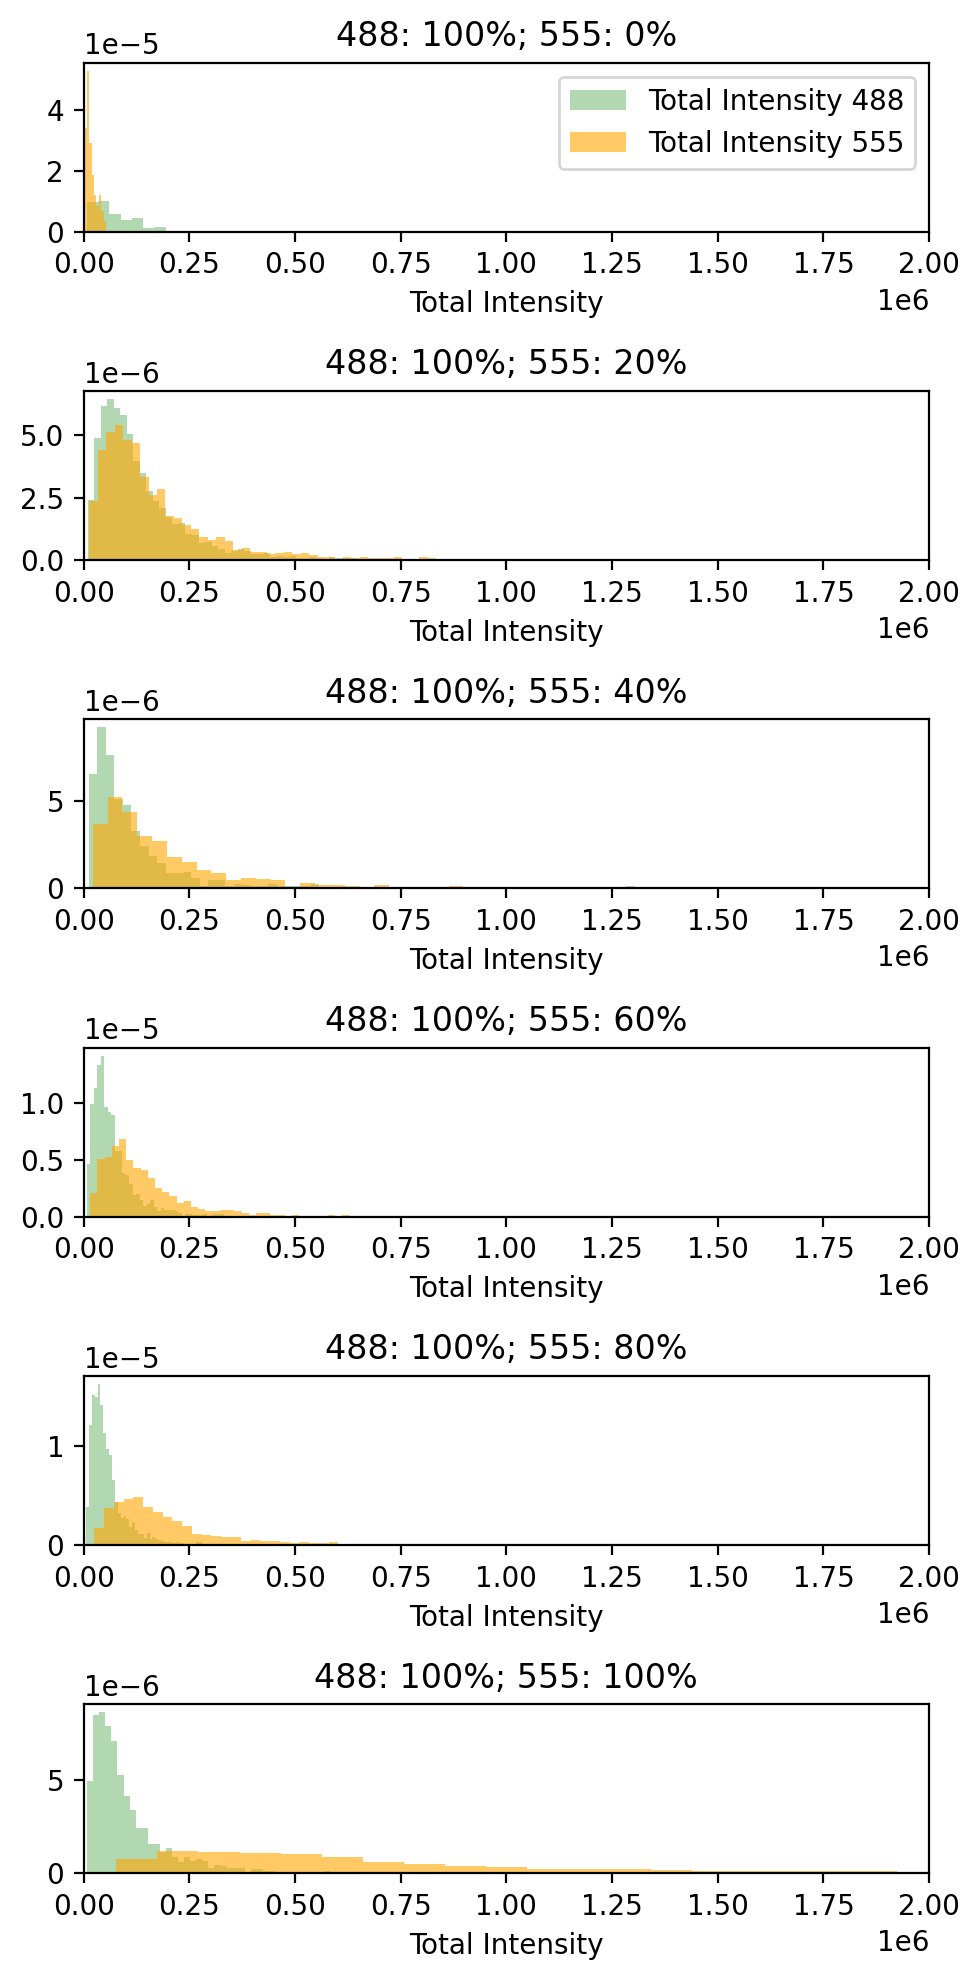

In [264]:
# for each filename, plot histogram of total_intensity_555 and total_intensity_488
plt.figure(figsize=(5, 10), dpi=200)
for i, filename in enumerate(df_all['filename'].unique()):
    plt.subplot(6, 1, i+1)
    df_temp = df_all[df_all['filename'] == filename]
    plt.hist(df_temp['total_intensity_488'], bins = 'auto', color='green', alpha=0.3, label='Total Intensity 488', density=True)
    plt.hist(df_temp['total_intensity_555'], bins = 'auto', color='orange', alpha=0.6, label='Total Intensity 555', density=True)
    plt.title(f"488: 100%; 555: {filename}%")
    plt.xlabel('Total Intensity')
    # plt.ylabel('Frequency')
    plt.xlim(0, 2e6)
    if i == 0:
        plt.legend()
    
plt.tight_layout()
plt.show()

In [237]:
# for each filename, compute the ratio of total_intensity_488 and total_intensity_555 and plot histogram on the same figure
# set a colormap with red
cmap = plt.get_cmap('Reds', len(df_all['filename'].unique())+1)


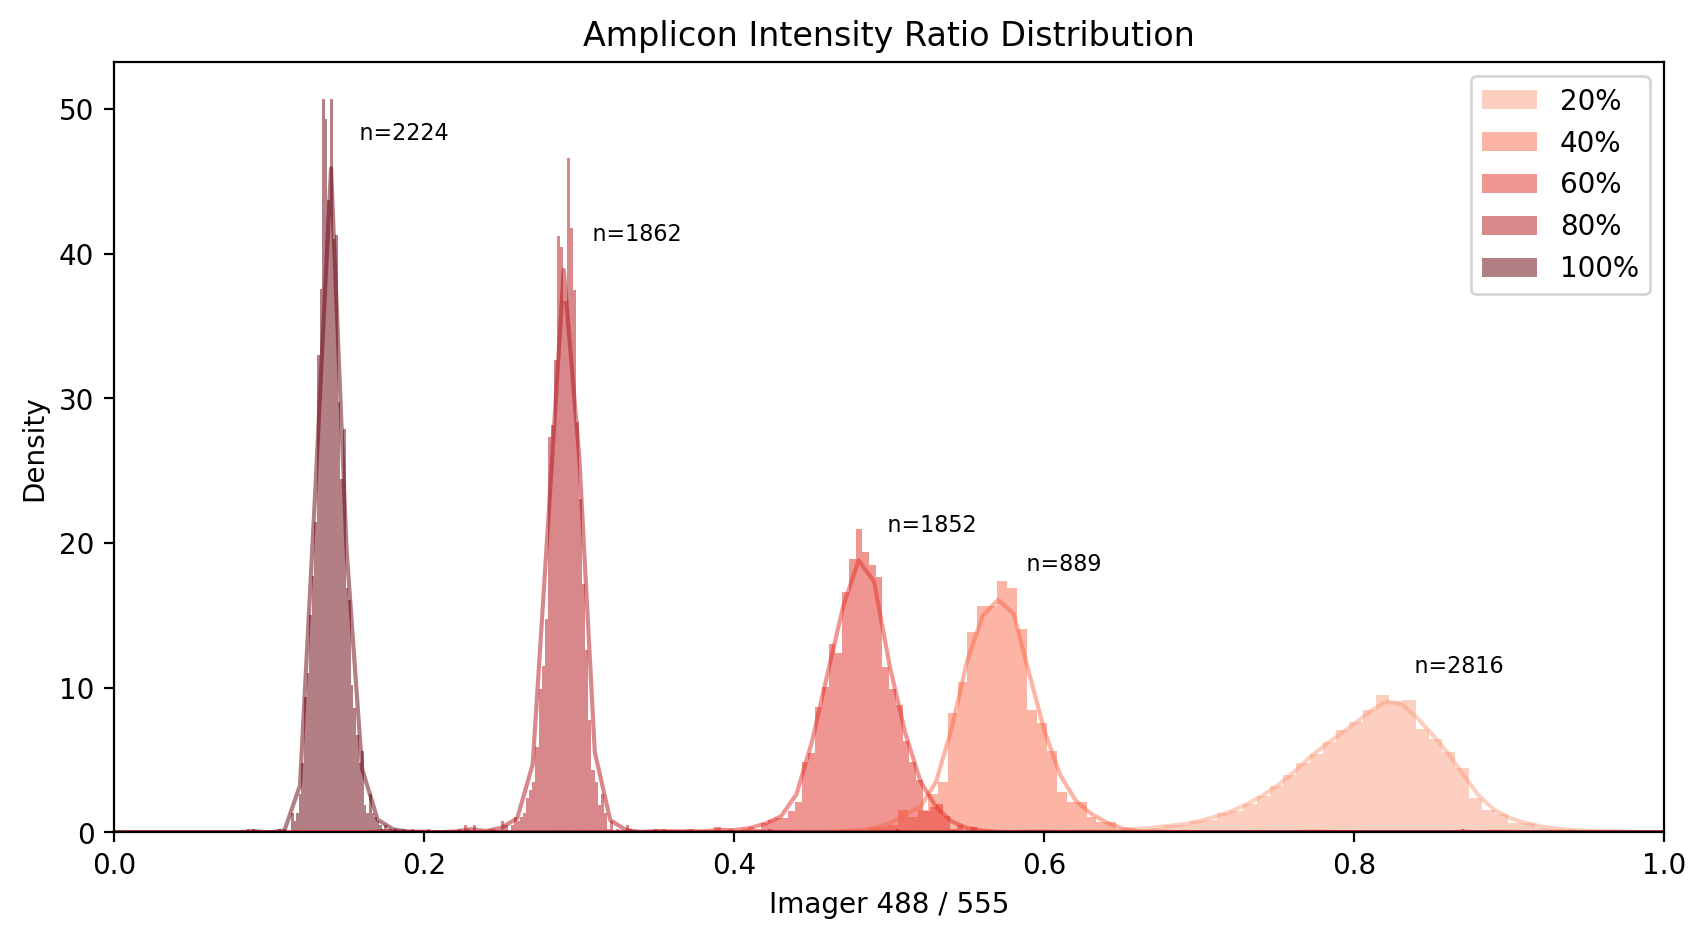

In [314]:
plt.figure(figsize=(10, 5), dpi=200)
for i, filename in enumerate(df_all['filename'].unique()):
    if i==0:
        continue
    df_temp = df_all[df_all['filename'] == filename]
    ratio = df_temp['total_intensity_488'] / df_temp['total_intensity_555']
    plt.hist(ratio, bins='auto', alpha=0.5, label=f"{filename}%", density=True, color=cmap(i+1))
    # plot a smoothened histogram of the intensity ratio
    kde = scipy.stats.gaussian_kde(ratio)
    x = np.linspace(0, 10, 1000)
    plt.plot(x, kde(x), alpha=0.5, color=cmap(i+1))
    # print the number of datapoints on top of each histogram peak
    count = len(ratio)
    peak_y = kde(x).max()
    peak_x = x[np.argmax(kde(x))]
    plt.text(peak_x, peak_y+2, f"    n={count}", fontsize=8, color="black")
plt.xlabel('Imager 488 / 555')
plt.ylabel('Density')
plt.title('Amplicon Intensity Ratio Distribution')
# set x into log scale
# plt.xscale('log')
plt.xlim(0, 1)
plt.legend()
plt.show()

762.6701053985046
678.5439617593297
599.3625876605357
587.644043383479
652.1175385054144


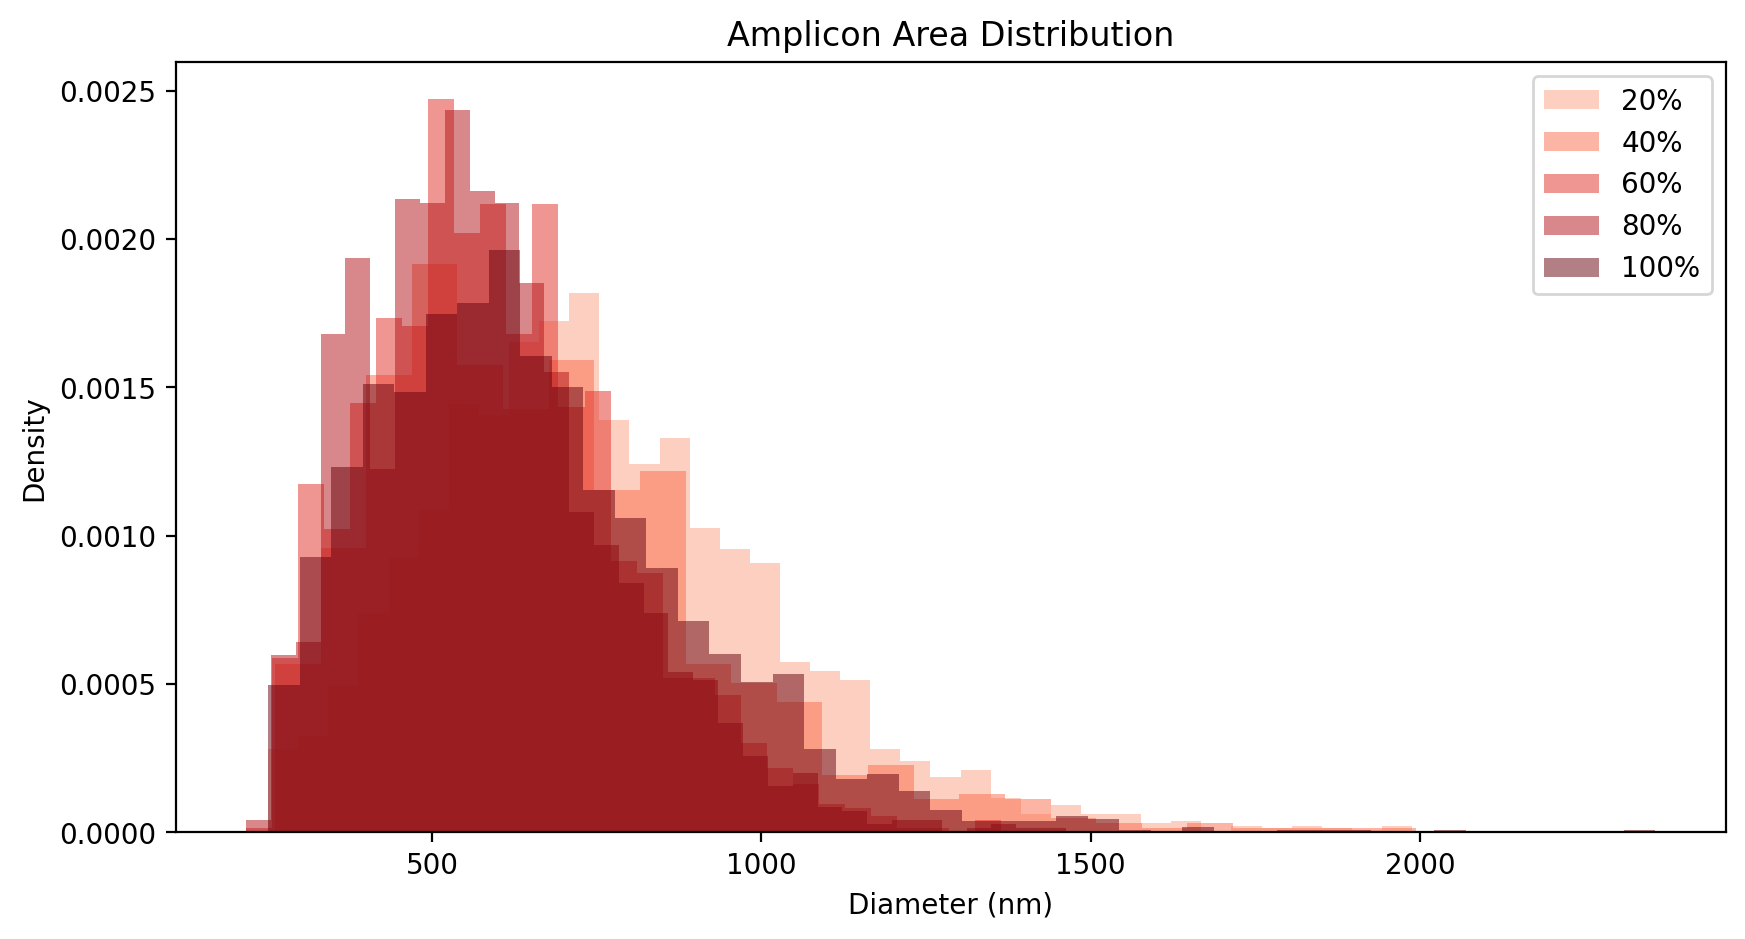

In [319]:
voxel_size = 0.0642498 # um/pixel

plt.figure(figsize=(10, 5), dpi=200)
for i, filename in enumerate(df_all['filename'].unique()):
    if i==0:
        continue
    df_temp = df_all[df_all['filename'] == filename]
    # assuming all areas are circle, compute the diameter
    diameter = np.sqrt(df_temp['area_488']/np.pi) * 2 * voxel_size * 1000
    print(diameter.mean())
    plt.hist(diameter, bins='auto', alpha=0.5, label=f"{filename}%", density=True, color=cmap(i+1))
    
plt.xlabel('Diameter (nm)')
plt.ylabel('Density')
plt.title('Amplicon Area Distribution')
# set x into log scale
# plt.xscale('log')
# plt.xlim(0, 1)
plt.legend()
plt.show()